In [197]:
#needed packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from random import randint
from tqdm import tqdm

import requests
from bs4 import BeautifulSoup
import time
from collections import Counter
from itertools import combinations

#local package
from project_functions import tag_text_clean, lotto_results_html_to_dict

In [2]:
#header to use to emulate web browser request instead of default python request
header = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36"}

#date format in date_range in month/day/year
dates = pd.date_range(start='1/1/2024', end='5/7/2024' )

url_date_string_format = "%d-%B-%Y"
url_base = "https://za.national-lottery.com/daily-lotto/results/"

In [7]:
daily_results_df = pd.DataFrame()
error_dates = []

#tqdm to show progress bar for loop
for date_obj in tqdm(dates):
    
    try:
        #date string in proper format for url
        date = datetime.strftime(date_obj, url_date_string_format)

        #webpage with results
        url = url_base + date 

         #obtain information about webapge
        response = requests.get(url, headers=header) 

        #transform response content to BeautifulSoup format
        html = BeautifulSoup(response.content, "html.parser")  

        lotto_result_df = pd.DataFrame( [lotto_results_html_to_dict(html, date)] )

        #add new result to results dataframe
        daily_results_df = pd.concat( [daily_results_df, lotto_result_df ], ignore_index=True)

        time.sleep( randint(2, 4) )
    except:
        error_dates.append( date )
        

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [08:09<00:00,  3.85s/it]


In [6]:
#some pages for some dates do not get scraped on the first try
#this is to try scrape those pages again

i = 0 #keep track of while loop

while len(error_dates) > 0:
    for date in tqdm(error_dates):

        #webpage with results
        url = url_base + date 

         #obtain information about webapge
        response = requests.get(url, headers=header) 

        #transform response content to BeautifulSoup format
        html = BeautifulSoup(response.content, "html.parser")  

        lotto_result_df = pd.DataFrame( [lotto_results_html_to_dict(html, date)] )

        #add new result to results dataframe
        daily_results_df = pd.concat( [daily_results_df, lotto_result_df ], ignore_index=True)

        time.sleep( randint(2, 4) )

    #remove date if succuesfully included into dataframe
    error_dates = [ date for date in error_dates if date not in daily_results_df['date'].values] 

    print(len(error_dates), len(daily_results_df) == len(dates))
    i += 1
    if i == 4:
        break

In [12]:
daily_results_df.tail(3)

,date,machine_name,N1,N2,N3,N4,N5,tickets_sold,jackpot,div1_wniners,div1_prize,div2_wniners,div2_prize,div3_wniners,div3_prize,div4_wniners,div4_prize,total_sales_R,total_winners,total_winnings
draw_number,,,,,,,,,,,,,,,,,,,,
1879,05-May-2024,NG 3,14,17,18,28,31,768795,410536.4,1,410536.4,301,314.2,8986,21.0,88481,5.2,2306385,97769,1153917.8
1880,06-May-2024,NG 3,3,6,10,11,31,997757,532802.4,3,177600.8,410,299.3,12812,19.1,123534,4.8,2993271,136759,1493187.8
1881,07-May-2024,NG 2,1,5,11,22,28,1157529,618120.5,5,123624.1,507,280.8,14952,19.1,142320,4.9,3472587,157784,1743437.30


In [20]:
daily_results_df['draw_number'] = daily_results_df['draw_number'].astype(str)
daily_results_df['date'] = pd.to_datetime(daily_results_df['date'], format=url_date_string_format )

In [17]:
daily_results_df.sort_values("draw_number", ascending=True, inplace=True)

#save results
daily_results_df.to_csv("daily_lotto_results.csv", index=True)

In [21]:
# daily_results_df = pd.read_csv("daily_lotto_results.csv")
# daily_results_df.head(3)

# ANALYSIS

In [166]:
#change to some default settings for plots
rcparams_update = {"figure.figsize":[14,8],
                   "xtick.labelsize":15,
                  "ytick.labelsize":15,
                   "axes.titlesize":18
                  }

plt.rcParams.update(rcparams_update)

fz = 18  #xlabel and ylabel fontsize


### 1. MOST FREQUENT AND LEAST FREQUENT NUMBERS

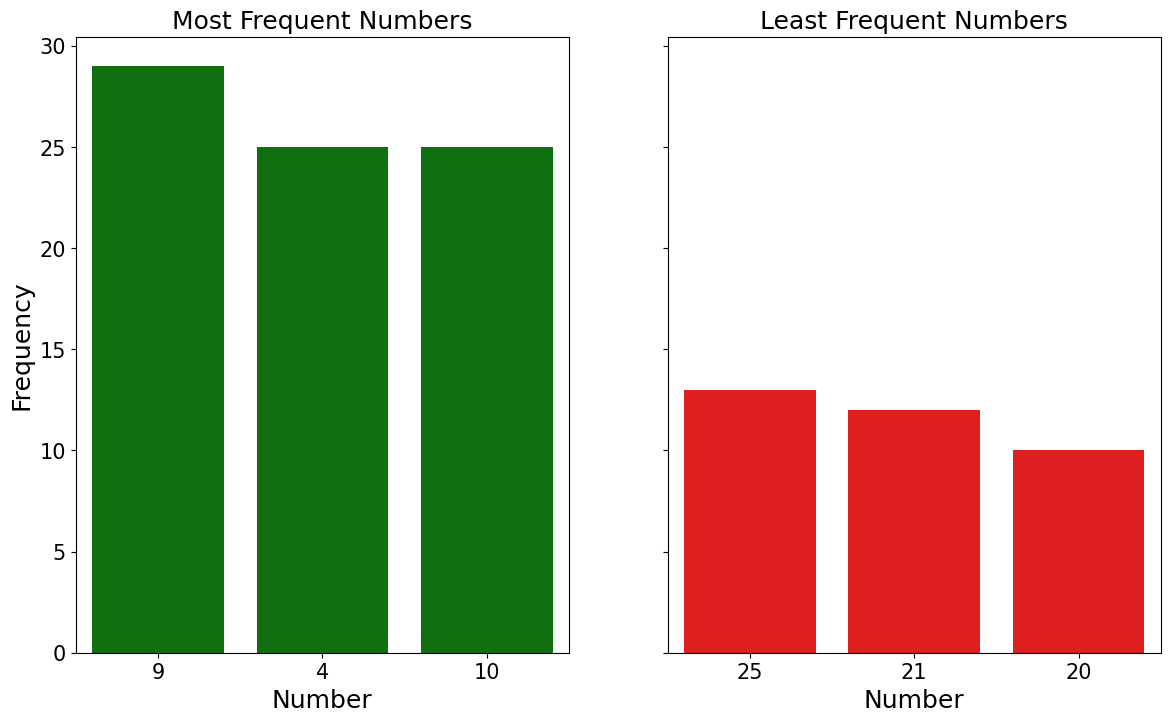

In [167]:
draws = [ set( daily_results_df.iloc[draw]["N1":"N5"].values ) for draw in range(len(daily_results_df))]

all_numbers = []
for draw in draws:
    all_numbers = all_numbers + list(draw)
    
number_count = pd.Series( Counter(all_numbers) ).sort_values(ascending=False)

#-----------------------------------------
#SHOW THE MOST AND LEAST FREQUENT NUMBERS
#-----------------------------------------

f, ax = plt.subplots(1, 2, sharey=True)

sns.countplot(ax=ax[0], x=all_numbers, color='green', order=number_count.index[:3])
ax[0].set_title("Most Frequent Numbers")
ax[0].set_ylabel("Frequency", fontsize=fz)
ax[0].set_xlabel("Number", fontsize=fz)

sns.countplot(ax=ax[1], x=all_numbers, color='red', order=number_count.index[-3:])
ax[1].set_title("Least Frequent Numbers")
ax[1].set_ylabel("", fontsize=fz)
ax[1].set_xlabel("Number", fontsize=fz)

plt.show()

### 2. How Many Numbers Do Consecutive Draws Have In Common? 

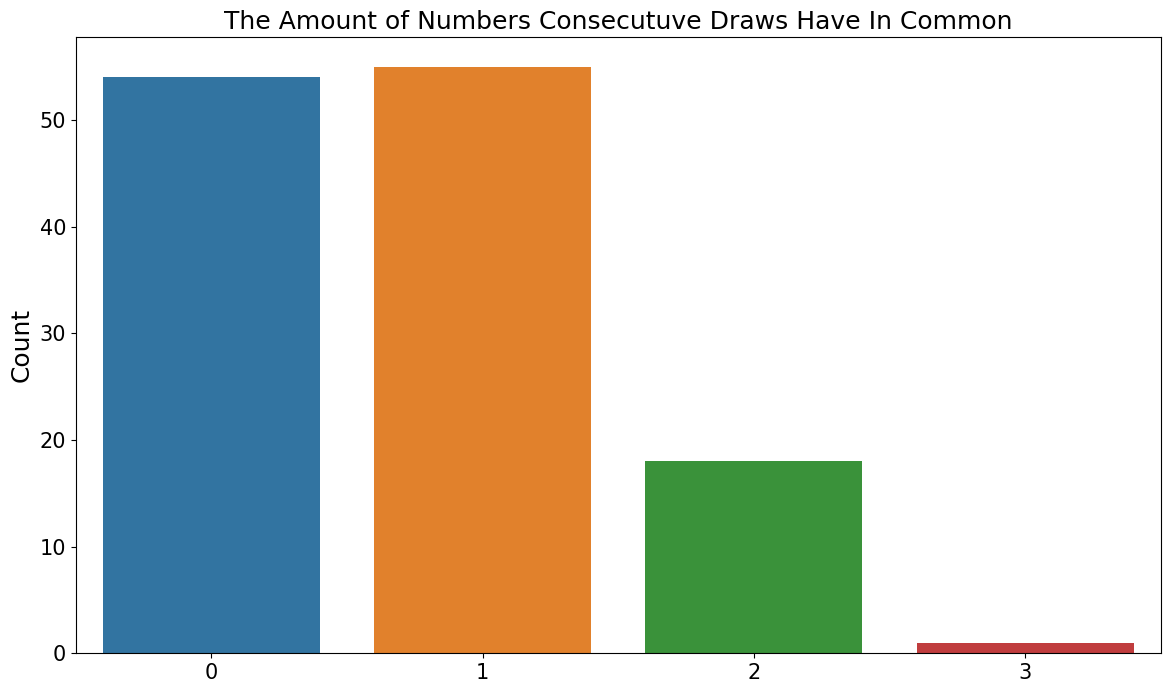

In [185]:
n_intersection = []

for i in range(len(draws)):
    draws_interection = draws[i].intersection(draws[i-1])
    n_intersection.append(len(draws_interection))
                                      

f, ax = plt.subplots(1,1)
sns.countplot(x=n_intersection, ax=ax)
plt.title("The Amount of Numbers Consecutuve Draws Have In Common")
plt.ylabel("Count", fontsize=fz)
plt.show()

### 3. Total Winnings vs Totals Sales 

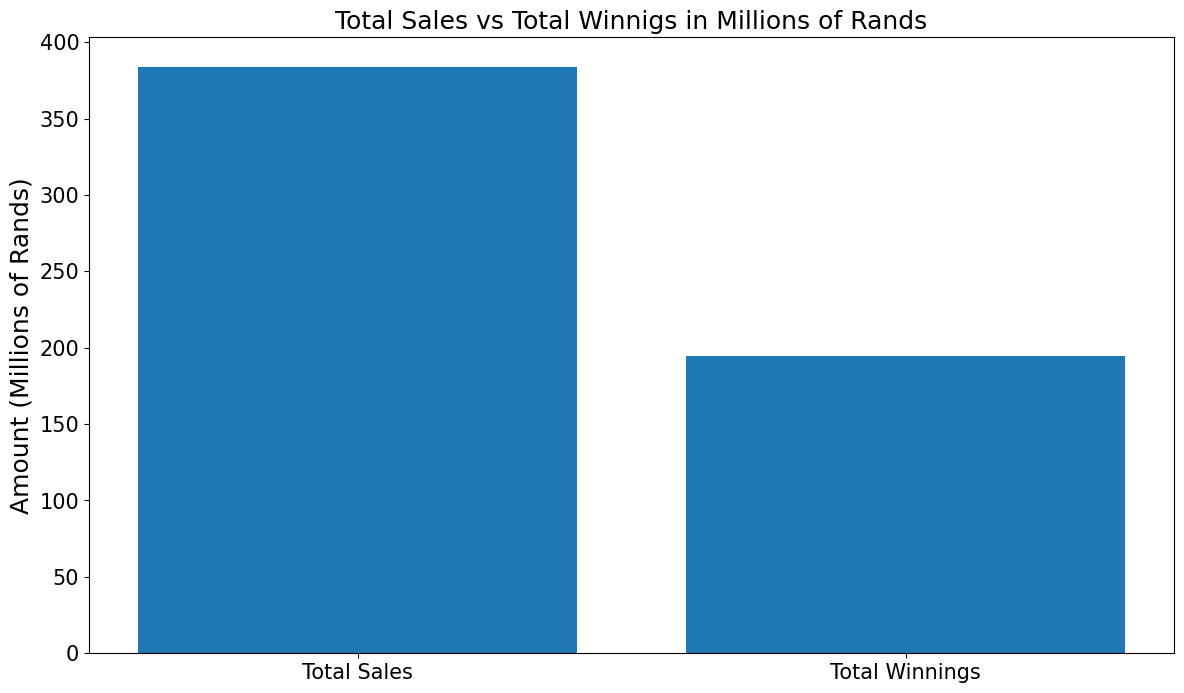

In [199]:
total_sales = daily_results_df['total_sales'].sum()
total_winnings = daily_results_df['total_winnings'].sum()

plt.figure()
plt.bar(['Total Sales', 'Total Winnings'], [total_sales/1e6, total_winnings / 1e6])
plt.title("Total Sales vs Total Winnigs in Millions of Rands")
plt.ylabel("Amount (Millions of Rands)", fontsize=fz)
plt.show()